<a href="https://colab.research.google.com/github/Sat-A/s5-jax/blob/main/simple_forecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple tokenised s5 forecaster

In [16]:
# Install required packages (run once)
# If you already have these installed, pip will skip them.
!pip -q install dm-haiku hippox jax jaxlib optax torch torchvision yfinance matplotlib --quiet


In [17]:
# Core imports and small helpers
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpy as np
import matplotlib.pyplot as plt
import dataclasses
from typing import Optional, Tuple, NamedTuple, Any, MutableMapping
from functools import partial

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import yfinance as yf

# Ensure reproducibility for CPU/PyTorch parts
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# Small tree util used by haiku RNN initial states
def add_batch(nest, batch_size: Optional[int]):
    broadcast = lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape)
    return jax.tree_util.tree_map(broadcast, nest)


In [18]:
# Discretize continuous A,B with zero-order hold (ZOH)
def discretize(A, B, delta_t):
    Identity = jnp.ones(A.shape[0])
    _A = jnp.exp(A * delta_t)
    _B = (1 / A * (_A - Identity))[..., None] * B
    return _A, _B

# log-step initializer for timescales
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(shape, dtype):
        uniform = hk.initializers.RandomUniform()
        return uniform(shape, dtype) * (jnp.log(dt_max) - jnp.log(dt_min)) + jnp.log(dt_min)
    return init

# init multiple log-steps (for MIMO state)
def init_log_steps(shape, dtype):
    H = shape[0]
    log_steps = []
    for i in range(H):
        log_step = log_step_initializer()(shape=(1,), dtype=dtype)
        log_steps.append(log_step)
    return jnp.array(log_steps)


In [19]:
# associative binary operator and parallel scan used by S5
@jax.vmap
def binary_operator(q_i, q_j):
    A_i, b_i = q_i
    A_j, b_j = q_j
    return A_j * A_i, A_j * b_i + b_j

def parallel_scan(A, B, C, inputs):
    A_elements = A * jnp.ones((inputs.shape[0], A.shape[0]))
    Bu_elements = jax.vmap(lambda u: B @ u)(inputs)
    _, xs = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements))
    return jax.vmap(lambda x: (C @ x).real)(xs)


In [20]:
# Linear SSM cell (RNN style) - kept for reference; not used directly in the seq-classifier but included for completeness.
from hippox.main import Hippo

class LinearSSM(hk.RNNCore):
    def __init__(self, state_size: int, name: Optional[str] = None):
        super(LinearSSM, self).__init__(name=name)
        _hippo = Hippo(state_size=state_size, basis_measure='legs')
        _hippo()

        self._state_size = state_size

        self._lambda_real = hk.get_parameter('lambda_real', shape=[state_size,], init=_hippo.lambda_initializer('real'))
        self._lambda_imag = hk.get_parameter('lambda_imaginary', shape=[state_size,], init=_hippo.lambda_initializer('imaginary'))

        self._A = self._lambda_real + 1j * self._lambda_imag

        self._B = hk.get_parameter('B', shape=[state_size,], init=_hippo.b_initializer())
        self._C = hk.get_parameter('C', shape=[state_size, 2], init=hk.initializers.RandomNormal(stddev=0.5**0.5))
        self._output_matrix = self._C[..., 0] + 1j * self._C[..., 1]

        self._D = hk.get_parameter('D', [1,], init=jnp.ones)

        self._delta_t = hk.get_parameter('delta_t', shape=[1,], init=log_step_initializer())
        timescale = jnp.exp(self._delta_t)

        self._state_matrix, self._input_matrix = discretize(self._A, self._B, timescale)

    def __call__(self, inputs, prev_state):
        u = inputs[:, jnp.newaxis]
        new_state = self._state_matrix @ prev_state + self._input_matrix @ u
        y_s = self._output_matrix @ new_state
        out = y_s.reshape(-1).real + self._D * u
        return out, new_state

    def initial_state(self, batch_size: Optional[int] = None):
        state = jnp.zeros([self._state_size])
        if batch_size is not None:
            state = add_batch(state, batch_size)
        return state


In [21]:
# S5 MIMO implementation using Hippox diagonalised initialiser
from hippox.main import Hippo

class S5(hk.Module):
    def __init__(self,
                 state_size: int,
                 d_model: int,
                 n_blocks: int,
                 conj_sym: bool = True,
                 clip_eigns: bool = False,
                 bidirectional: bool = False,
                 step_rescale: float = 1.0,
                 name: Optional[str] = None):
        super(S5, self).__init__(name=name)
        self.conj_sym = conj_sym
        self.bidirectional = bidirectional

        if conj_sym:
            _state_size = state_size // 2
        else:
            _state_size = state_size

        _hippo = Hippo(
            state_size=state_size,
            basis_measure='legs',
            conj_sym=conj_sym,
            block_diagonal=True,
            n_blocks=n_blocks,
        )
        _hippo()

        self._lambda_real = hk.get_parameter('lambda_real', [_state_size], init=_hippo.lambda_initializer('real'))
        self._lambda_imag = hk.get_parameter('lambda_imaginary', [_state_size], init=_hippo.lambda_initializer('imaginary'))
        if clip_eigns:
            self._A = jnp.clip(self._lambda_real, None, -1e-4) + 1j * self._lambda_imag
        else:
            self._A = self._lambda_real + 1j * self._lambda_imag

        # B and C initialisation via Hippo transforms (concatenated to hold real+imag parts)
        b_init = hk.initializers.VarianceScaling()
        b_shape = [state_size, d_model]
        b_init_val = b_init(b_shape, dtype=jnp.complex64)
        self._B = hk.get_parameter('B', [_state_size, d_model, 2], init=_hippo.eigenvector_transform(b_init_val, concatenate=True))
        B = self._B[..., 0] + 1j * self._B[..., 1]

        c_init = hk.initializers.TruncatedNormal()
        c_shape = [d_model, state_size, 2]
        c_init_val = c_init(c_shape, dtype=jnp.complex64)
        self._C = hk.get_parameter('C', [d_model, _state_size, 2], init=_hippo.eigenvector_transform(c_init_val, inverse=False, concatenate=True))

        if bidirectional:
            self._C2 = hk.get_parameter('C2', [d_model, _state_size, 2], init=_hippo.eigenvector_transform(c_init_val, inverse=False, concatenate=True))
            C1 = self._C[..., 0] + 1j * self._C[..., 1]
            C2 = self._C2[..., 0] + 1j * self._C2[..., 1]
            self._output_matrix = jnp.concatenate((C1, C2), axis=-1)
        else:
            self._output_matrix = self._C[..., 0] + 1j * self._C[..., 1]

        self._D = hk.get_parameter('D', [d_model,], init=hk.initializers.RandomNormal(stddev=1.0))

        self._delta_t = hk.get_parameter('delta_T', [_state_size, 1], init=init_log_steps)
        timescale = step_rescale * jnp.exp(self._delta_t[:, 0])

        self._state_matrix, self._input_matrix = discretize(self._A, B, timescale)

    def __call__(self, inputs):
        # inputs shape: (seq_len, d_model_input) when called for a single example
        A_elements = self._state_matrix * jnp.ones((inputs.shape[0], self._state_matrix.shape[0]))
        Bu_elements = jax.vmap(lambda u: self._input_matrix @ u)(inputs)

        _, xs = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements))

        if self.bidirectional:
            _, xs2 = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements), reverse=True)
            xs = jnp.concatenate((xs, xs2), axis=-1)

        if self.conj_sym:
            ys = jax.vmap(lambda x: 2 * (self._output_matrix @ x).real)(xs)
        else:
            ys = jax.vmap(lambda x: (self._output_matrix @ x).real)(xs)

        Du = jax.vmap(lambda u: self._D * u)(inputs)
        return ys + Du


In [22]:
# Block and stack wrappers and the classifier that supports per-time-step sequence outputs.
@dataclasses.dataclass
class S5Block(hk.Module):
    ssm: S5
    d_model: int
    dropout_rate: float
    prenorm: bool
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Block, self).__post_init__(name=self.name)
        self._norm = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
        self._linear = hk.Linear(self.d_model)

    def __call__(self, x):
        # x shape: (seq_len, d_model)
        skip = x
        if self.prenorm:
            x = self._norm(x)

        x = self.ssm(x)
        x1 = hk.dropout(hk.next_rng_key(), self.dropout_rate, jax.nn.gelu(x))
        x = x * jax.nn.sigmoid(self._linear(x1))
        x = hk.dropout(hk.next_rng_key(), self.dropout_rate, x)

        x = skip + x
        if not self.prenorm:
            x = self._norm(x)
        return x

@dataclasses.dataclass
class S5Stack(hk.Module):
    ssm: S5
    d_model: int
    n_layers: int
    dropout_rate: float
    prenorm: bool
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Stack, self).__post_init__(name=self.name)
        self._encoder = hk.Linear(self.d_model)
        self._layers = [S5Block(ssm=self.ssm, d_model=self.d_model, dropout_rate=self.dropout_rate, istraining=self.istraining, prenorm=self.prenorm) for _ in range(self.n_layers)]

    def __call__(self, x):
        # x shape: (seq_len, d_input)
        x = self._encoder(x)
        for layer in self._layers:
            x = layer(x)
        return x

@dataclasses.dataclass
class S5Classifier(hk.Module):
    ssm: S5
    d_model: int
    d_output: int
    n_layers: int
    dropout_rate: float
    mode: str = 'seq'   # 'pool', 'last', 'seq'
    prenorm: bool = True
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Classifier, self).__post_init__(name=self.name)
        self._encoder = S5Stack(ssm=self.ssm, d_model=self.d_model, n_layers=self.n_layers, dropout_rate=self.dropout_rate, istraining=self.istraining, prenorm=self.prenorm)
        self._decoder = hk.Linear(self.d_output)

    def __call__(self, x):
        # x shape (seq_len, d_input)
        x = self._encoder(x)  # (seq_len, d_model)
        if self.mode == 'pool':
            x = jnp.mean(x, axis=0)
            x = self._decoder(x)
            return jax.nn.log_softmax(x, axis=-1)
        elif self.mode == 'last':
            x = x[-1]
            x = self._decoder(x)
            return jax.nn.log_softmax(x, axis=-1)
        elif self.mode == 'seq':
            seq_len = x.shape[0]
            x_flat = jnp.reshape(x, (-1, self.d_model))
            logits_flat = self._decoder(x_flat)  # (seq_len, d_output)
            logits = jnp.reshape(logits_flat, (seq_len, -1))  # (seq_len, d_output)
            return jax.nn.log_softmax(logits, axis=-1)
        else:
            raise NotImplementedError("Mode must be in ['pool', 'last', 'seq']")


In [23]:
# Create stock dataset: download closes, compute log-returns, scale them and discretise into bins.
def create_stock_prediction_dataset(
    ticker: str = "AAPL",
    period: str = "2y",
    interval: str = "1d",
    seq_length: int = 128,
    batch_size: int = 64,
    n_bins: int = 50,
    binning_strategy: str = "quantile",
    normalize_prices: bool = True,
):
    print(f"[*] Downloading {ticker} history ({period}, {interval})...")
    df = yf.Ticker(ticker).history(period=period, interval=interval)
    closes = df["Close"].to_numpy().astype(np.float64)

    if len(closes) < seq_length + 2:
        raise ValueError("Not enough historical points for requested seq_length")

    # Compute log returns r_t = ln(p_t / p_{t-1})
    log_returns = np.log(closes[1:] / closes[:-1])  # length N-1

    # Normalise returns for training stability (but tokens computed on scaled values)
    if normalize_prices:
        mu, sigma = log_returns.mean(), log_returns.std()
        log_returns_scaled = (log_returns - mu) / (sigma + 1e-12)
    else:
        mu, sigma = 0.0, 1.0
        log_returns_scaled = log_returns.copy()

    # Bin edges
    if binning_strategy == "quantile":
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.quantile(log_returns_scaled, quantiles)
        bins = np.unique(bins)
        n_bins = len(bins) - 1
    elif binning_strategy == "uniform":
        mn, mx = log_returns_scaled.min(), log_returns_scaled.max()
        bins = np.linspace(mn, mx, n_bins + 1)
    else:
        raise ValueError("Unsupported binning_strategy")

    # Digitize into tokens 0..n_bins-1
    tokens = np.digitize(log_returns_scaled, bins[1:-1], right=False).astype(np.int64)

    # Build sliding windows: inputs are scaled returns (seq_length,1), targets are next-step tokens for each time
    X, Y = [], []
    total_len = len(tokens)
    for start in range(0, total_len - seq_length):
        x = log_returns_scaled[start : start + seq_length]
        y = tokens[start + 1 : start + seq_length + 1]
        X.append(x[:, None])
        Y.append(y)

    X = np.stack(X)  # (n_samples, seq_length, 1)
    Y = np.stack(Y)  # (n_samples, seq_length)

    # Train/test split 80/20
    n_samples = X.shape[0]
    split = int(n_samples * 0.8)
    perm = np.arange(n_samples)
    np.random.shuffle(perm)
    train_idx, test_idx = perm[:split], perm[split:]

    X_train, Y_train = X[train_idx], Y[train_idx]
    X_test, Y_test = X[test_idx], Y[test_idx]

    # Torch dataloaders for convenience with the rest of the notebook
    X_train_t = torch.from_numpy(X_train).float()
    Y_train_t = torch.from_numpy(Y_train).long()
    X_test_t = torch.from_numpy(X_test).float()
    Y_test_t = torch.from_numpy(Y_test).long()

    trainloader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=batch_size, shuffle=True)
    testloader = DataLoader(TensorDataset(X_test_t, Y_test_t), batch_size=batch_size, shuffle=False)

    meta = {
        "bins": bins,
        "n_bins": n_bins,
        "normalize": normalize_prices,
        "mu": float(mu),
        "sigma": float(sigma),
        "raw_closes": closes,
    }

    print("[*] Dataset ready.")
    return trainloader, testloader, n_bins, seq_length, 1, meta


In [24]:
# Hyperparameters (adjust to taste)
STATE_SIZE: int = 128
D_MODEL: int = 64
N_LAYERS: int = 3
N_BLOCKS: int = 4
EPOCHS: int = 50
BATCH_SIZE: int = 64
DROPOUT_RATE: float = 0.1
LEARNING_RATE: float = 1e-3
SEED = 0

# Create dataset (example: AAPL 2 years daily)
trainloader, testloader, N_BINS, SEQ_LENGTH, IN_DIM, ds_meta = create_stock_prediction_dataset(
    ticker="SPY",
    period="2y",
    interval="1d",
    seq_length=128,
    batch_size=BATCH_SIZE,
    n_bins=50,
    binning_strategy="quantile",
    normalize_prices=True,
)

# Lightweight Dataset object to be compatible with earlier code style
class Dataset(NamedTuple):
    trainloader: DataLoader
    testloader: DataLoader
    n_classes: int
    seq_length: int
    d_input: int
    classification: bool

ds = Dataset(trainloader, testloader, N_BINS, SEQ_LENGTH, IN_DIM, True)


[*] Downloading SPY history (2y, 1d)...
[*] Dataset ready.


In [25]:
# Optimiser and training state
class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState
    rng_key: jnp.ndarray

optimiser = optax.adam(LEARNING_RATE)

# Loss and metrics for sequence classification
def cross_entropy_loss_sequence(logits: jnp.ndarray, targets: jnp.ndarray) -> jnp.ndarray:
    # logits: (batch, seq_len, n_classes) in log-probabilities
    nll = -jnp.take_along_axis(logits, targets[..., None], axis=-1).squeeze(-1)
    return jnp.mean(nll)

def compute_accuracy_sequence(logits: jnp.ndarray, targets: jnp.ndarray) -> jnp.ndarray:
    preds = jnp.argmax(logits, axis=-1)
    return jnp.mean(preds == targets)


In [26]:
# JIT-compiled update and evaluate functions
@partial(jax.jit, static_argnums=(3,4))
def update(
    state: TrainingState,
    inputs: jnp.ndarray,    # (batch, seq_len, d_input)
    targets: jnp.ndarray,   # (batch, seq_len)
    model: hk.Transformed,
    classification: bool,
) -> Tuple[TrainingState, MutableMapping[str, Any]]:
    rng_key, next_rng_key = jax.random.split(state.rng_key)

    def loss_fn(params):
        logits = model.apply(params, rng_key, inputs)  # (batch, seq_len, n_bins) expected
        if logits.ndim == 3:
            loss = cross_entropy_loss_sequence(logits, targets)
            acc = compute_accuracy_sequence(logits, targets)
        else:
            # fallback (single output)
            loss = jnp.mean(jax.vmap(lambda l, t: -jnp.sum(jax.nn.one_hot(t, l.shape[-1]) * jax.nn.log_softmax(l)))(logits, targets))
            acc = jnp.mean(jnp.argmax(logits, axis=-1) == targets)
        return loss, acc

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, accuracy), gradients = grad_fn(state.params)
    updates, new_opt_state = optimiser.update(gradients, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(params=new_params, opt_state=new_opt_state, rng_key=next_rng_key)
    metrics = {'loss': loss, 'accuracy': accuracy}
    return new_state, metrics

@partial(jax.jit, static_argnums=(3,4))
def evaluate(
    state: TrainingState,
    inputs: jnp.ndarray,
    targets: jnp.ndarray,
    model: hk.Transformed,
    classification: bool,
) -> MutableMapping[str, Any]:
    rng_key, _ = jax.random.split(state.rng_key, 2)
    logits = model.apply(state.params, rng_key, inputs)
    if logits.ndim == 3:
        loss = cross_entropy_loss_sequence(logits, targets)
        accuracy = compute_accuracy_sequence(logits, targets)
    else:
        loss = jnp.mean(jax.vmap(lambda l, t: -jnp.sum(jax.nn.one_hot(t, l.shape[-1]) * jax.nn.log_softmax(l)))(logits, targets))
        accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == targets)
    return {'loss': loss, 'accuracy': accuracy}


In [27]:
# Training and validation loops (use tqdm for progress)
from tqdm import tqdm

def training_epoch(
    state: TrainingState,
    trainloader: DataLoader,
    model: hk.Transformed,
    classification: bool = True,
) -> Tuple[TrainingState, float, float]:
    batch_losses, batch_accuracies = [], []
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs = jnp.array(inputs.numpy())   # (batch, seq_len, 1)
        targets = jnp.array(targets.numpy()) # (batch, seq_len)
        state, metrics = update(state, inputs, targets, model, classification)
        batch_losses.append(metrics['loss'])
        batch_accuracies.append(metrics['accuracy'])
    return state, float(jnp.mean(jnp.array(batch_losses))), float(jnp.mean(jnp.array(batch_accuracies)))

def validation_epoch(
    state: TrainingState,
    testloader: DataLoader,
    model: hk.Transformed,
    classification: bool = True,
) -> Tuple[float, float]:
    losses, accuracies = [], []
    for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
        inputs = jnp.array(inputs.numpy())
        targets = jnp.array(targets.numpy())
        metrics = evaluate(state, inputs, targets, model, classification)
        losses.append(metrics['loss'])
        accuracies.append(metrics['accuracy'])
    return float(jnp.mean(jnp.array(losses))), float(jnp.mean(jnp.array(accuracies)))


In [28]:
# Build transformed forward function producing per-time-step logits (mode='seq').
@hk.transform
def forward(x):
    neural_net = S5Classifier(
        S5(STATE_SIZE, D_MODEL, N_BLOCKS),
        D_MODEL,
        ds.n_classes,
        N_LAYERS,
        DROPOUT_RATE,
        mode='seq',
    )
    return hk.vmap(neural_net, split_rng=False)(x)

# Initialise parameters using one batch from trainloader
key = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(key)
init_batch = next(iter(ds.trainloader))[0]  # torch tensor (batch, seq_len, 1)
init_data = jnp.array(init_batch.numpy())

initial_params = forward.init(init_rng, init_data)
initial_opt_state = optimiser.init(initial_params)
state = TrainingState(params=initial_params, opt_state=initial_opt_state, rng_key=rng)


/usr/local/lib/python3.12/dist-packages/jax/_src/lax/lax.py:1660: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)  # type: ignore[unused-ignore,bad-return-type]


In [29]:
# Training loop
for epoch in range(EPOCHS):
    print(f"[*] Training Epoch {epoch + 1}...")
    state, train_loss, train_acc = training_epoch(state, ds.trainloader, forward, ds.classification)
    print(f"[*] Running Epoch {epoch + 1} Validation...")
    test_loss, test_acc = validation_epoch(state, ds.testloader, forward, ds.classification)
    print(f"\n=>> Epoch {epoch + 1} Metrics ===")
    print(f"\tTrain Loss: {train_loss:.5f} -- Train Accuracy: {train_acc:.4f}\n\tTest Loss: {test_loss:.5f} -- Test Accuracy: {test_acc:.4f}")


[*] Training Epoch 1...


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/jax/_src/lax/lax.py:5473: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 5/5 [00:42<00:00,  8.44s/it]


[*] Running Epoch 1 Validation...


100%|██████████| 2/2 [00:09<00:00,  4.98s/it]



=>> Epoch 1 Metrics ===
	Train Loss: 7.78279 -- Train Accuracy: 0.0231
	Test Loss: 6.36507 -- Test Accuracy: 0.0236
[*] Training Epoch 2...


100%|██████████| 5/5 [00:00<00:00, 223.93it/s]


[*] Running Epoch 2 Validation...


100%|██████████| 2/2 [00:00<00:00, 272.78it/s]



=>> Epoch 2 Metrics ===
	Train Loss: 5.80005 -- Train Accuracy: 0.0291
	Test Loss: 5.15955 -- Test Accuracy: 0.0291
[*] Training Epoch 3...


100%|██████████| 5/5 [00:00<00:00, 239.26it/s]


[*] Running Epoch 3 Validation...


100%|██████████| 2/2 [00:00<00:00, 137.93it/s]



=>> Epoch 3 Metrics ===
	Train Loss: 4.89764 -- Train Accuracy: 0.0350
	Test Loss: 4.58439 -- Test Accuracy: 0.0424
[*] Training Epoch 4...


100%|██████████| 5/5 [00:00<00:00, 103.55it/s]


[*] Running Epoch 4 Validation...


100%|██████████| 2/2 [00:00<00:00, 258.32it/s]



=>> Epoch 4 Metrics ===
	Train Loss: 4.41501 -- Train Accuracy: 0.0456
	Test Loss: 4.21563 -- Test Accuracy: 0.0534
[*] Training Epoch 5...


100%|██████████| 5/5 [00:00<00:00, 164.35it/s]


[*] Running Epoch 5 Validation...


100%|██████████| 2/2 [00:00<00:00, 191.76it/s]



=>> Epoch 5 Metrics ===
	Train Loss: 4.09954 -- Train Accuracy: 0.0570
	Test Loss: 3.99644 -- Test Accuracy: 0.0622
[*] Training Epoch 6...


100%|██████████| 5/5 [00:00<00:00, 195.18it/s]


[*] Running Epoch 6 Validation...


100%|██████████| 2/2 [00:00<00:00, 245.32it/s]



=>> Epoch 6 Metrics ===
	Train Loss: 3.89537 -- Train Accuracy: 0.0705
	Test Loss: 3.84385 -- Test Accuracy: 0.0761
[*] Training Epoch 7...


100%|██████████| 5/5 [00:00<00:00, 155.33it/s]


[*] Running Epoch 7 Validation...


100%|██████████| 2/2 [00:00<00:00, 233.37it/s]



=>> Epoch 7 Metrics ===
	Train Loss: 3.73878 -- Train Accuracy: 0.0871
	Test Loss: 3.69257 -- Test Accuracy: 0.0953
[*] Training Epoch 8...


100%|██████████| 5/5 [00:00<00:00, 257.25it/s]


[*] Running Epoch 8 Validation...


100%|██████████| 2/2 [00:00<00:00, 517.27it/s]



=>> Epoch 8 Metrics ===
	Train Loss: 3.62078 -- Train Accuracy: 0.1015
	Test Loss: 3.55556 -- Test Accuracy: 0.1100
[*] Training Epoch 9...


100%|██████████| 5/5 [00:00<00:00, 99.53it/s]


[*] Running Epoch 9 Validation...


100%|██████████| 2/2 [00:00<00:00, 290.82it/s]



=>> Epoch 9 Metrics ===
	Train Loss: 3.50679 -- Train Accuracy: 0.1233
	Test Loss: 3.45810 -- Test Accuracy: 0.1264
[*] Training Epoch 10...


100%|██████████| 5/5 [00:00<00:00, 175.15it/s]


[*] Running Epoch 10 Validation...


100%|██████████| 2/2 [00:00<00:00, 291.76it/s]



=>> Epoch 10 Metrics ===
	Train Loss: 3.42553 -- Train Accuracy: 0.1385
	Test Loss: 3.37945 -- Test Accuracy: 0.1497
[*] Training Epoch 11...


100%|██████████| 5/5 [00:00<00:00, 156.98it/s]


[*] Running Epoch 11 Validation...


100%|██████████| 2/2 [00:00<00:00, 194.17it/s]



=>> Epoch 11 Metrics ===
	Train Loss: 3.33431 -- Train Accuracy: 0.1611
	Test Loss: 3.29452 -- Test Accuracy: 0.1670
[*] Training Epoch 12...


100%|██████████| 5/5 [00:00<00:00, 253.74it/s]


[*] Running Epoch 12 Validation...


100%|██████████| 2/2 [00:00<00:00, 227.00it/s]



=>> Epoch 12 Metrics ===
	Train Loss: 3.23860 -- Train Accuracy: 0.1783
	Test Loss: 3.19303 -- Test Accuracy: 0.1935
[*] Training Epoch 13...


100%|██████████| 5/5 [00:00<00:00, 148.95it/s]


[*] Running Epoch 13 Validation...


100%|██████████| 2/2 [00:00<00:00, 158.76it/s]



=>> Epoch 13 Metrics ===
	Train Loss: 3.14310 -- Train Accuracy: 0.2012
	Test Loss: 3.10410 -- Test Accuracy: 0.2097
[*] Training Epoch 14...


100%|██████████| 5/5 [00:00<00:00, 112.04it/s]


[*] Running Epoch 14 Validation...


100%|██████████| 2/2 [00:00<00:00, 179.10it/s]



=>> Epoch 14 Metrics ===
	Train Loss: 3.04555 -- Train Accuracy: 0.2255
	Test Loss: 3.00969 -- Test Accuracy: 0.2419
[*] Training Epoch 15...


100%|██████████| 5/5 [00:00<00:00, 244.23it/s]


[*] Running Epoch 15 Validation...


100%|██████████| 2/2 [00:00<00:00, 274.18it/s]



=>> Epoch 15 Metrics ===
	Train Loss: 2.94747 -- Train Accuracy: 0.2494
	Test Loss: 2.91672 -- Test Accuracy: 0.2582
[*] Training Epoch 16...


100%|██████████| 5/5 [00:00<00:00, 188.83it/s]


[*] Running Epoch 16 Validation...


100%|██████████| 2/2 [00:00<00:00, 214.56it/s]



=>> Epoch 16 Metrics ===
	Train Loss: 2.85344 -- Train Accuracy: 0.2727
	Test Loss: 2.80392 -- Test Accuracy: 0.2846
[*] Training Epoch 17...


100%|██████████| 5/5 [00:00<00:00, 254.92it/s]


[*] Running Epoch 17 Validation...


100%|██████████| 2/2 [00:00<00:00, 239.14it/s]



=>> Epoch 17 Metrics ===
	Train Loss: 2.73125 -- Train Accuracy: 0.2961
	Test Loss: 2.70845 -- Test Accuracy: 0.3153
[*] Training Epoch 18...


100%|██████████| 5/5 [00:00<00:00, 179.97it/s]


[*] Running Epoch 18 Validation...


100%|██████████| 2/2 [00:00<00:00, 107.43it/s]



=>> Epoch 18 Metrics ===
	Train Loss: 2.62699 -- Train Accuracy: 0.3240
	Test Loss: 2.59201 -- Test Accuracy: 0.3377
[*] Training Epoch 19...


100%|██████████| 5/5 [00:00<00:00, 204.43it/s]


[*] Running Epoch 19 Validation...


100%|██████████| 2/2 [00:00<00:00, 288.66it/s]



=>> Epoch 19 Metrics ===
	Train Loss: 2.52687 -- Train Accuracy: 0.3484
	Test Loss: 2.48878 -- Test Accuracy: 0.3519
[*] Training Epoch 20...


100%|██████████| 5/5 [00:00<00:00, 220.37it/s]


[*] Running Epoch 20 Validation...


100%|██████████| 2/2 [00:00<00:00, 238.35it/s]



=>> Epoch 20 Metrics ===
	Train Loss: 2.41648 -- Train Accuracy: 0.3764
	Test Loss: 2.36609 -- Test Accuracy: 0.3859
[*] Training Epoch 21...


100%|██████████| 5/5 [00:00<00:00, 212.64it/s]


[*] Running Epoch 21 Validation...


100%|██████████| 2/2 [00:00<00:00, 146.32it/s]



=>> Epoch 21 Metrics ===
	Train Loss: 2.29992 -- Train Accuracy: 0.4055
	Test Loss: 2.26586 -- Test Accuracy: 0.4187
[*] Training Epoch 22...


100%|██████████| 5/5 [00:00<00:00, 268.04it/s]


[*] Running Epoch 22 Validation...


100%|██████████| 2/2 [00:00<00:00, 195.35it/s]



=>> Epoch 22 Metrics ===
	Train Loss: 2.19508 -- Train Accuracy: 0.4330
	Test Loss: 2.19633 -- Test Accuracy: 0.4258
[*] Training Epoch 23...


100%|██████████| 5/5 [00:00<00:00, 243.04it/s]


[*] Running Epoch 23 Validation...


100%|██████████| 2/2 [00:00<00:00, 205.11it/s]



=>> Epoch 23 Metrics ===
	Train Loss: 2.08567 -- Train Accuracy: 0.4634
	Test Loss: 2.05305 -- Test Accuracy: 0.4811
[*] Training Epoch 24...


100%|██████████| 5/5 [00:00<00:00, 183.20it/s]


[*] Running Epoch 24 Validation...


100%|██████████| 2/2 [00:00<00:00, 208.16it/s]



=>> Epoch 24 Metrics ===
	Train Loss: 1.97768 -- Train Accuracy: 0.4939
	Test Loss: 1.95998 -- Test Accuracy: 0.4868
[*] Training Epoch 25...


100%|██████████| 5/5 [00:00<00:00, 180.45it/s]


[*] Running Epoch 25 Validation...


100%|██████████| 2/2 [00:00<00:00, 208.98it/s]



=>> Epoch 25 Metrics ===
	Train Loss: 1.89221 -- Train Accuracy: 0.5124
	Test Loss: 1.85431 -- Test Accuracy: 0.5205
[*] Training Epoch 26...


100%|██████████| 5/5 [00:00<00:00, 247.58it/s]


[*] Running Epoch 26 Validation...


100%|██████████| 2/2 [00:00<00:00, 336.15it/s]



=>> Epoch 26 Metrics ===
	Train Loss: 1.79642 -- Train Accuracy: 0.5423
	Test Loss: 1.75544 -- Test Accuracy: 0.5576
[*] Training Epoch 27...


100%|██████████| 5/5 [00:00<00:00, 237.07it/s]


[*] Running Epoch 27 Validation...


100%|██████████| 2/2 [00:00<00:00, 143.89it/s]



=>> Epoch 27 Metrics ===
	Train Loss: 1.69151 -- Train Accuracy: 0.5687
	Test Loss: 1.67429 -- Test Accuracy: 0.5701
[*] Training Epoch 28...


100%|██████████| 5/5 [00:00<00:00, 92.67it/s]


[*] Running Epoch 28 Validation...


100%|██████████| 2/2 [00:00<00:00, 164.51it/s]



=>> Epoch 28 Metrics ===
	Train Loss: 1.60547 -- Train Accuracy: 0.5942
	Test Loss: 1.61215 -- Test Accuracy: 0.5948
[*] Training Epoch 29...


100%|██████████| 5/5 [00:00<00:00, 173.85it/s]


[*] Running Epoch 29 Validation...


100%|██████████| 2/2 [00:00<00:00, 279.42it/s]



=>> Epoch 29 Metrics ===
	Train Loss: 1.53667 -- Train Accuracy: 0.6098
	Test Loss: 1.52901 -- Test Accuracy: 0.6072
[*] Training Epoch 30...


100%|██████████| 5/5 [00:00<00:00, 164.22it/s]


[*] Running Epoch 30 Validation...


100%|██████████| 2/2 [00:00<00:00, 271.49it/s]



=>> Epoch 30 Metrics ===
	Train Loss: 1.44462 -- Train Accuracy: 0.6330
	Test Loss: 1.42585 -- Test Accuracy: 0.6411
[*] Training Epoch 31...


100%|██████████| 5/5 [00:00<00:00, 131.45it/s]


[*] Running Epoch 31 Validation...


100%|██████████| 2/2 [00:00<00:00, 216.80it/s]



=>> Epoch 31 Metrics ===
	Train Loss: 1.37954 -- Train Accuracy: 0.6550
	Test Loss: 1.35613 -- Test Accuracy: 0.6513
[*] Training Epoch 32...


100%|██████████| 5/5 [00:00<00:00, 196.20it/s]


[*] Running Epoch 32 Validation...


100%|██████████| 2/2 [00:00<00:00, 130.51it/s]



=>> Epoch 32 Metrics ===
	Train Loss: 1.32323 -- Train Accuracy: 0.6659
	Test Loss: 1.30522 -- Test Accuracy: 0.6672
[*] Training Epoch 33...


100%|██████████| 5/5 [00:00<00:00, 109.17it/s]


[*] Running Epoch 33 Validation...


100%|██████████| 2/2 [00:00<00:00, 388.04it/s]



=>> Epoch 33 Metrics ===
	Train Loss: 1.26142 -- Train Accuracy: 0.6832
	Test Loss: 1.27091 -- Test Accuracy: 0.6836
[*] Training Epoch 34...


100%|██████████| 5/5 [00:00<00:00, 298.64it/s]


[*] Running Epoch 34 Validation...


100%|██████████| 2/2 [00:00<00:00, 147.52it/s]



=>> Epoch 34 Metrics ===
	Train Loss: 1.21698 -- Train Accuracy: 0.6946
	Test Loss: 1.21136 -- Test Accuracy: 0.6950
[*] Training Epoch 35...


100%|██████████| 5/5 [00:00<00:00, 248.24it/s]


[*] Running Epoch 35 Validation...


100%|██████████| 2/2 [00:00<00:00, 193.36it/s]



=>> Epoch 35 Metrics ===
	Train Loss: 1.16621 -- Train Accuracy: 0.7072
	Test Loss: 1.16533 -- Test Accuracy: 0.7090
[*] Training Epoch 36...


100%|██████████| 5/5 [00:00<00:00, 172.99it/s]


[*] Running Epoch 36 Validation...


100%|██████████| 2/2 [00:00<00:00, 159.63it/s]



=>> Epoch 36 Metrics ===
	Train Loss: 1.12234 -- Train Accuracy: 0.7148
	Test Loss: 1.11773 -- Test Accuracy: 0.7215
[*] Training Epoch 37...


100%|██████████| 5/5 [00:00<00:00, 182.90it/s]


[*] Running Epoch 37 Validation...


100%|██████████| 2/2 [00:00<00:00, 251.42it/s]



=>> Epoch 37 Metrics ===
	Train Loss: 1.08520 -- Train Accuracy: 0.7271
	Test Loss: 1.06048 -- Test Accuracy: 0.7294
[*] Training Epoch 38...


100%|██████████| 5/5 [00:00<00:00, 100.99it/s]


[*] Running Epoch 38 Validation...


100%|██████████| 2/2 [00:00<00:00, 253.85it/s]



=>> Epoch 38 Metrics ===
	Train Loss: 1.03688 -- Train Accuracy: 0.7408
	Test Loss: 1.02603 -- Test Accuracy: 0.7398
[*] Training Epoch 39...


100%|██████████| 5/5 [00:00<00:00, 231.50it/s]


[*] Running Epoch 39 Validation...


100%|██████████| 2/2 [00:00<00:00, 329.99it/s]



=>> Epoch 39 Metrics ===
	Train Loss: 0.99772 -- Train Accuracy: 0.7501
	Test Loss: 1.02106 -- Test Accuracy: 0.7403
[*] Training Epoch 40...


100%|██████████| 5/5 [00:00<00:00, 267.90it/s]


[*] Running Epoch 40 Validation...


100%|██████████| 2/2 [00:00<00:00, 115.23it/s]



=>> Epoch 40 Metrics ===
	Train Loss: 0.98037 -- Train Accuracy: 0.7547
	Test Loss: 0.97651 -- Test Accuracy: 0.7485
[*] Training Epoch 41...


100%|██████████| 5/5 [00:00<00:00, 249.00it/s]


[*] Running Epoch 41 Validation...


100%|██████████| 2/2 [00:00<00:00, 191.63it/s]



=>> Epoch 41 Metrics ===
	Train Loss: 0.93678 -- Train Accuracy: 0.7648
	Test Loss: 0.93747 -- Test Accuracy: 0.7602
[*] Training Epoch 42...


100%|██████████| 5/5 [00:00<00:00, 183.29it/s]


[*] Running Epoch 42 Validation...


100%|██████████| 2/2 [00:00<00:00, 145.91it/s]



=>> Epoch 42 Metrics ===
	Train Loss: 0.90664 -- Train Accuracy: 0.7746
	Test Loss: 0.90835 -- Test Accuracy: 0.7743
[*] Training Epoch 43...


100%|██████████| 5/5 [00:00<00:00, 104.94it/s]


[*] Running Epoch 43 Validation...


100%|██████████| 2/2 [00:00<00:00, 300.24it/s]



=>> Epoch 43 Metrics ===
	Train Loss: 0.88149 -- Train Accuracy: 0.7802
	Test Loss: 0.90738 -- Test Accuracy: 0.7691
[*] Training Epoch 44...


100%|██████████| 5/5 [00:00<00:00, 195.20it/s]


[*] Running Epoch 44 Validation...


100%|██████████| 2/2 [00:00<00:00, 150.83it/s]



=>> Epoch 44 Metrics ===
	Train Loss: 0.85410 -- Train Accuracy: 0.7859
	Test Loss: 0.85057 -- Test Accuracy: 0.7798
[*] Training Epoch 45...


100%|██████████| 5/5 [00:00<00:00, 251.03it/s]


[*] Running Epoch 45 Validation...


100%|██████████| 2/2 [00:00<00:00, 242.14it/s]



=>> Epoch 45 Metrics ===
	Train Loss: 0.84349 -- Train Accuracy: 0.7871
	Test Loss: 0.83582 -- Test Accuracy: 0.7920
[*] Training Epoch 46...


100%|██████████| 5/5 [00:00<00:00, 151.82it/s]


[*] Running Epoch 46 Validation...


100%|██████████| 2/2 [00:00<00:00, 109.54it/s]



=>> Epoch 46 Metrics ===
	Train Loss: 0.81299 -- Train Accuracy: 0.7968
	Test Loss: 0.83027 -- Test Accuracy: 0.7889
[*] Training Epoch 47...


100%|██████████| 5/5 [00:00<00:00, 100.57it/s]


[*] Running Epoch 47 Validation...


100%|██████████| 2/2 [00:00<00:00, 282.70it/s]



=>> Epoch 47 Metrics ===
	Train Loss: 0.79041 -- Train Accuracy: 0.8008
	Test Loss: 0.80296 -- Test Accuracy: 0.7945
[*] Training Epoch 48...


100%|██████████| 5/5 [00:00<00:00, 159.93it/s]


[*] Running Epoch 48 Validation...


100%|██████████| 2/2 [00:00<00:00, 137.55it/s]



=>> Epoch 48 Metrics ===
	Train Loss: 0.77460 -- Train Accuracy: 0.8056
	Test Loss: 0.80392 -- Test Accuracy: 0.7865
[*] Training Epoch 49...


100%|██████████| 5/5 [00:00<00:00, 220.88it/s]


[*] Running Epoch 49 Validation...


100%|██████████| 2/2 [00:00<00:00, 268.06it/s]



=>> Epoch 49 Metrics ===
	Train Loss: 0.75695 -- Train Accuracy: 0.8092
	Test Loss: 0.76121 -- Test Accuracy: 0.8073
[*] Training Epoch 50...


100%|██████████| 5/5 [00:00<00:00, 222.21it/s]


[*] Running Epoch 50 Validation...


100%|██████████| 2/2 [00:00<00:00, 244.20it/s]


=>> Epoch 50 Metrics ===
	Train Loss: 0.73501 -- Train Accuracy: 0.8164
	Test Loss: 0.73114 -- Test Accuracy: 0.8144


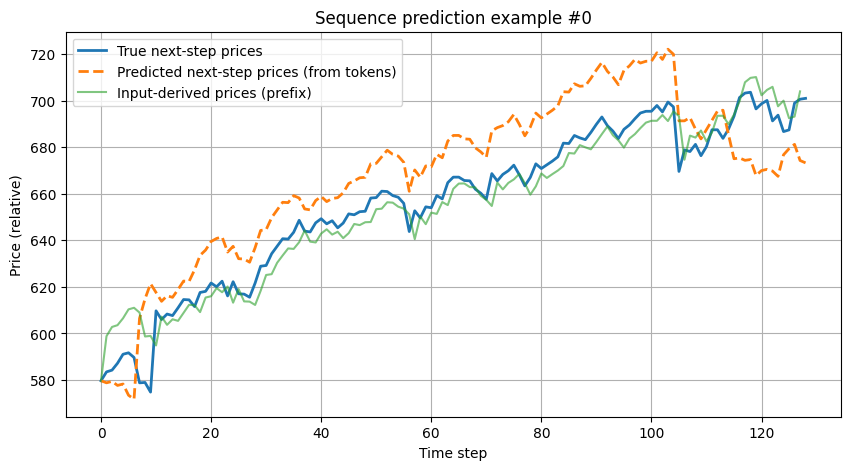

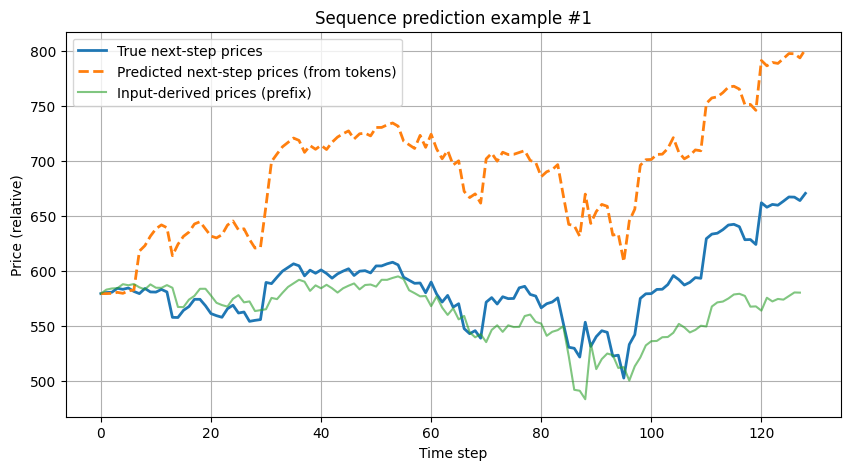

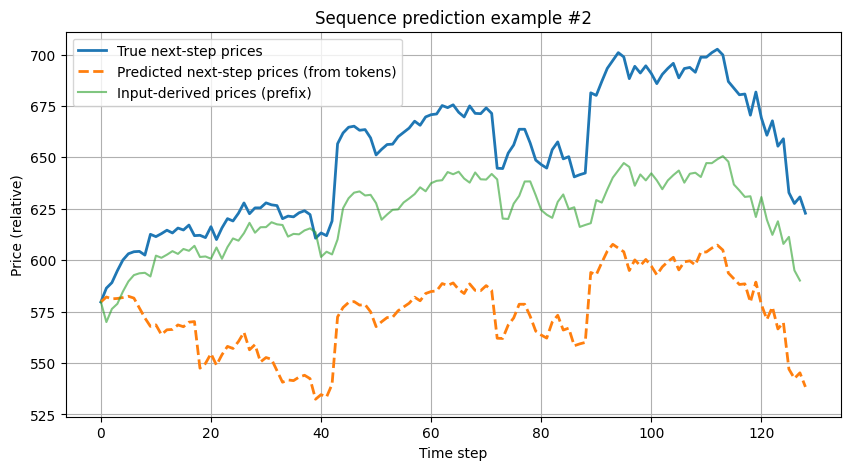

In [30]:
# Plotting utilities to visualise predicted vs actual price trajectories for some examples.
def tokens_to_return_midpoints(tokens: np.ndarray, bins: np.ndarray) -> np.ndarray:
    mids = 0.5 * (bins[:-1] + bins[1:])
    return mids[tokens]

def reconstruct_prices_from_returns(initial_price: float, returns: np.ndarray, mu: float, sigma: float) -> np.ndarray:
    unscaled = returns * sigma + mu
    prices = [initial_price]
    for r in unscaled:
        prices.append(prices[-1] * np.exp(r))
    return np.array(prices)

def plot_batch_predictions(params, model_forward, dataloader, meta, n_examples: int = 3):
    batch = next(iter(dataloader))
    X_batch_t, Y_batch_t = batch
    X_batch = jnp.array(X_batch_t.numpy())
    Y_batch = Y_batch_t.numpy()
    rng_key = jax.random.PRNGKey(0)
    logits = model_forward.apply(params, rng_key, X_batch)  # (batch, seq_len, n_bins)
    probs = jnp.exp(logits)
    preds = jnp.argmax(probs, axis=-1)

    bins = meta["bins"]
    mu = meta["mu"]
    sigma = meta["sigma"]
    closes = meta["raw_closes"]

    for i in range(min(n_examples, X_batch.shape[0])):
        x_returns = np.array(X_batch[i, :, 0])   # scaled log-returns input
        true_tokens = Y_batch[i]
        pred_tokens = np.array(preds[i])

        # Determine an initial price for reconstruction. Use the last available close if possible:
        if len(closes) >= len(x_returns) + 2:
            initial_price = float(closes[-(len(x_returns) + 2)])
        else:
            initial_price = float(closes[-1])

        true_ret_mids = tokens_to_return_midpoints(true_tokens, bins)
        pred_ret_mids = tokens_to_return_midpoints(pred_tokens, bins)

        true_prices = reconstruct_prices_from_returns(initial_price, true_ret_mids, mu, sigma)
        pred_prices = reconstruct_prices_from_returns(initial_price, pred_ret_mids, mu, sigma)
        input_prices = reconstruct_prices_from_returns(initial_price, x_returns, mu, sigma)

        t_axis = np.arange(len(true_prices))

        plt.figure(figsize=(10, 5))
        plt.plot(t_axis, true_prices, label="True next-step prices", linewidth=2)
        plt.plot(t_axis, pred_prices, label="Predicted next-step prices (from tokens)", linewidth=2, linestyle="--")
        plt.plot(t_axis[:-1], input_prices[:-1], label="Input-derived prices (prefix)", alpha=0.6)
        plt.xlabel("Time step")
        plt.ylabel("Price (relative)")
        plt.title(f"Sequence prediction example #{i}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Example call: plot three examples from the test set
plot_batch_predictions(params=state.params, model_forward=forward, dataloader=ds.testloader, meta=ds_meta, n_examples=3)
